# Example of applying Cross-Spectrum Analysis
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_objective_analysis/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_objective_analysis/blob/main/code/cross_spectrum_example.ipynb)

Steps for performing cross-spectrum analysis and interpreting the Coherence-squared and Quadrature spectrum.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
from scipy import stats

import matplotlib as mpl
# set figure defaults
mpl.rcParams['figure.dpi'] = 150
plt.rcParams['figure.figsize'] = (12.0/2, 8.0/2)

# specify whether running on Colab or locally
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
print('IN_COLAB = ' + str(IN_COLAB))

IN_COLAB = False


In [2]:
# set random seed so we get identical results every time
%env PYTHONHASHSEED=99
np.random.seed(99)

env: PYTHONHASHSEED=99


### Get your data together

As we have done so many times, to demonstrate how cross-spectrum analysis works we are going to define two red-noise time series with lag-one autocorrelations of alpha. We are also going to add some cosines of different frequencies and amplitudes to these time series to give them some oscillatory power. 

In [3]:
# define chunks for analysis
chunk_length = 256
num_chunks= 10
n = chunk_length*num_chunks

In [4]:
# generate red noise time series with autocorrelation
alpha = 0.5
height = 2.0
factor = np.sqrt(1.-alpha*alpha)

x = np.zeros((n,))
y = np.zeros((n,))
pnum = 0

x[0] = x[-1]*alpha + factor*np.random.randn()
y[0] = y[-1]*alpha + factor*np.random.randn()
for j in np.arange(1,n):
    
    # make data actually related
    x[j] = x[j-1]*alpha + factor*np.random.randn()+0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*63./256*j-np.pi/4.)
    y[j] = y[j-1]*alpha + factor*np.random.randn()+0.75*np.cos(2.*np.pi*(1.-.001*np.random.randn())*63./256*j)\
           + 1.0*np.cos(2.*np.pi*(1.-0.01*np.random.randn())*10./256.*j)

    # uncomment to make x and y totally random and unrelated
#     x[j] = x[j-1]*alpha + factor*np.random.randn()
#     y[j] = y[j-1]*(alpha/2.) + (np.sqrt(1.-alpha*alpha/4.))*np.random.randn()
    
    
xa = x - np.mean(x)
ya = y - np.mean(y)
print(xa[2])

0.5163678791867932


A few important points:
* x and y were both given power at freq = 0.24 = 63/256 cycles/timestep, however, x is phase shifted pi/4 compared to y
* y is given extra power at freq = 0.04=10/256 cycles/timestep

Let's plot our data so we can get a feeling for what it looks like. 

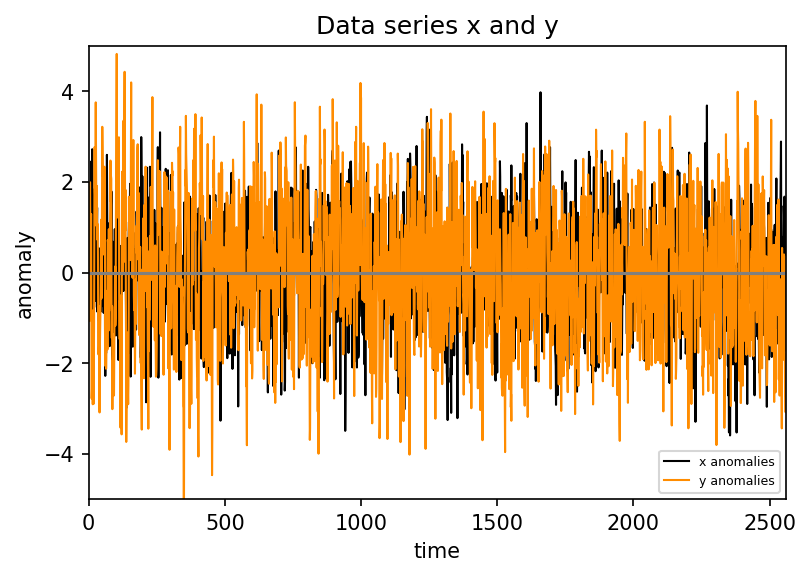

In [5]:
t = np.arange(1,np.size(x)+1)

plt.figure()
plt.plot(t,xa,'-k',linewidth = 1, label = 'x anomalies')
plt.plot(t,ya,'-', color = 'darkorange',linewidth = 1, label = 'y anomalies')

plt.xlim(0,np.size(t)+1)
plt.ylim(-5,5)
plt.xlabel('time')
plt.ylabel('anomaly')
plt.title('Data series x and y')
plt.legend(fontsize = 6)
plt.axhline(y=0,color='gray')
plt.show()

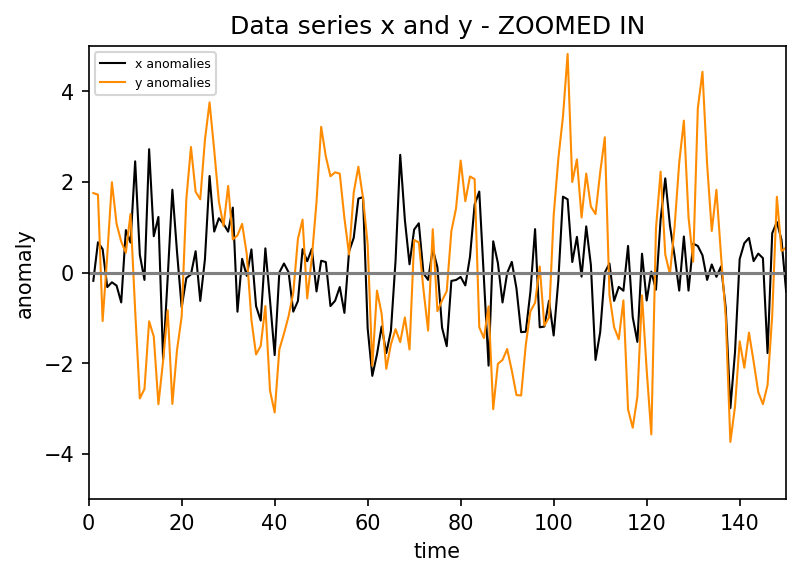

In [6]:
plt.figure()
plt.plot(t,xa,'-k',linewidth = 1, label = 'x anomalies')
plt.plot(t,ya,'-', color = 'darkorange',linewidth = 1, label = 'y anomalies')

plt.xlim(0,np.size(t)+1)
plt.ylim(-5,5)
plt.xlabel('time')
plt.ylabel('anomaly')
plt.axhline(y=0,color='gray')
plt.xlim(0,150)
plt.title('Data series x and y - ZOOMED IN')
plt.legend(fontsize = 6)
plt.show()

Note that y (orange) has lower frequencies than x (black). Let's see if this pops out of our analysis too!

### Analyze individual power spectra
Before jumping into cross-spectrum analysis, let's first just calculate the spectra for each time series separately to make sure we understand what is going on (and understand our software!). Note that these calculations will come in handy when we debug our cross-spectrum code too.

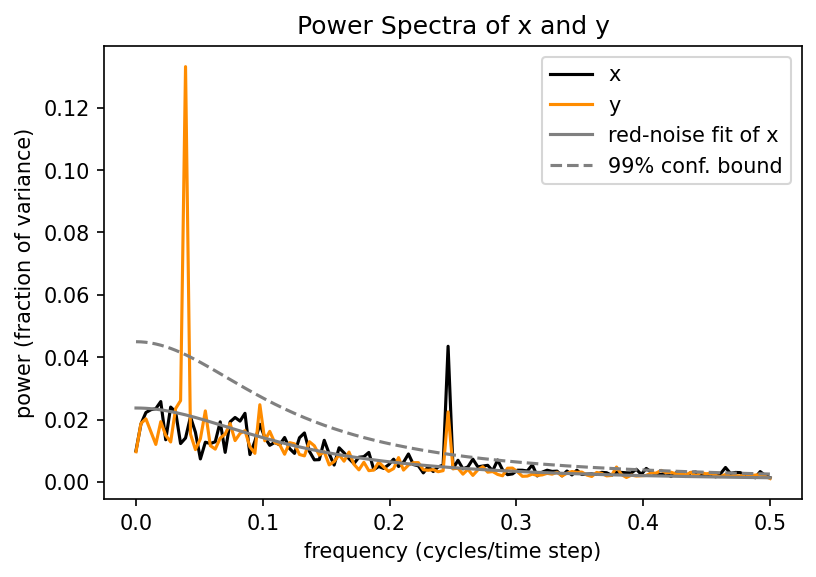

In [7]:
#%% calculate and plot spectrum of x and y
win_rect = np.ones(int(np.size(t)/float(num_chunks)),)

F, Pxx = sig.csd(xa, xa, window = win_rect, noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = np.size(t)/float(num_chunks), scaling = 'density', detrend = False)
F, Pyy = sig.csd(ya, ya, window = win_rect, noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = np.size(t)/float(num_chunks), scaling = 'density', detrend = False)

plt.figure()
plt.plot(F,Pxx/np.sum(Pxx),'-k', label = 'x')
plt.plot(F,Pyy/np.sum(Pyy),'-', color = 'darkorange', label = 'y')

plt.title('Power Spectra of x and y')
plt.ylabel('power (fraction of variance)')
plt.xlabel('frequency (cycles/time step)')

# calculate and plot red-noise fit of x (and probably y too since they have similar lag-1 autocorrelations)
alpha = sig.correlate(xa,xa,'full')
alpha = alpha/np.max(alpha)
alpha = alpha[int(np.size(alpha)/2)+1]
Te = -1./np.log(alpha)
rnoise = 2.8*2*Te/(1+(Te**2)*(F*2*np.pi)**2)
rnoise = rnoise/np.sum(rnoise)
dof = 2*num_chunks
fst = stats.f.ppf(.99,dof,1000)
spec99 = fst*rnoise

# plot red-noise results
plt.plot(F,rnoise,'-',color = 'gray', label = 'red-noise fit of x')
plt.plot(F,spec99,'--',color = 'gray', label = '99% conf. bound')

plt.legend()
plt.show()

OK - this plot has a lot in it...so let's dissect:
* both x and y look a lot like red-noise except for the few peaks here and there
* y has more power than x at a low frequency of freq = 0.04 cycles/time step, 
* both x and y have power around freq = 0.25 (63/256) cycles/time step - as coded

### Cross-spectrum Analysis

Now let's apply cross-spectrum analysis. Before I go off and publish a paper on this stuff I like to make sure I understand my software! Note that python has a built-in cross-spectrum command (sig.csd and sig.coherence), however, before I use it I want to ensure that I understand it. Hence, in some of the lines of code below I calculate the cross-spectra of x with itself and y with itself and combine then to get the coherence-squared to make sure it gives me the same coherence that sig.coherence does.

In [8]:
# use an overlap of 0.5

# calculate the squared coherence of x and y
F, Cxy = sig.coherence(xa, ya, window = win_rect, noverlap = chunk_length/2, nperseg = chunk_length, \
                       nfft = np.size(t)/float(num_chunks), detrend = False)

#--------------------------------------------------------------------------------------------------------------
# check that we understand scipy's sig.coherence code by calculating the
# coherence ourselves

#   calculate the cross-spectrum (both real and imaginary parts; i.e. Fxy)
F, Pxy = sig.csd(xa, ya, window = win_rect, noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = np.size(t)/float(num_chunks), scaling = 'density', detrend = False)
F, Pxx = sig.csd(xa, xa, window = win_rect, noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = np.size(t)/float(num_chunks), scaling = 'density', detrend = False)
F, Pyy = sig.csd(ya, ya, window = win_rect, noverlap = chunk_length/2, nperseg = chunk_length, \
                 nfft = np.size(t)/float(num_chunks), scaling = 'density', detrend = False)
CoherCheck = (np.abs(Pxy)**2)/(Pxx*Pyy)

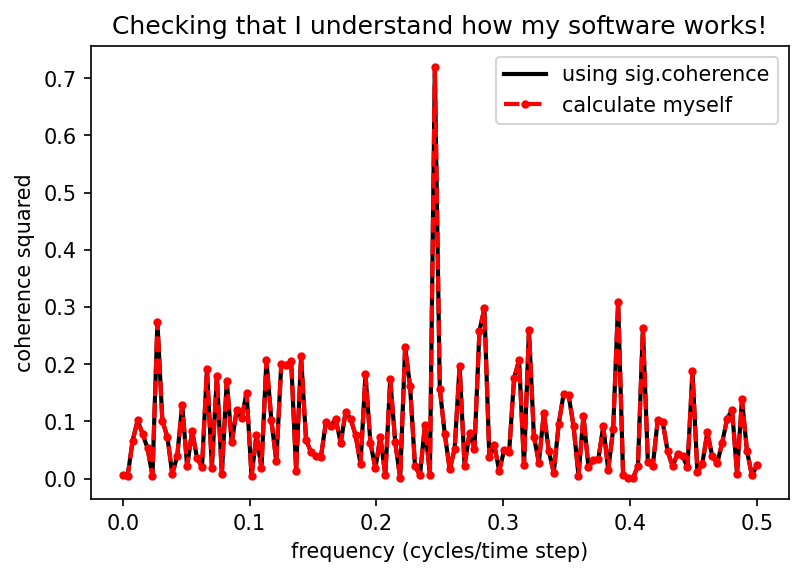

In [9]:
plt.figure()
plt.plot(F,Cxy,'-k',linewidth = 2, label='using sig.coherence')
plt.plot(F,CoherCheck,'.--r',linewidth = 2,label='calculate myself')
plt.title('Checking that I understand how my software works!')
plt.ylabel('coherence squared')
plt.xlabel('frequency (cycles/time step)')
plt.legend()
plt.show()

Hurray - looks like it works! I'm ready to actually use these functions.

Below I first plot the coherence squared between x and y.

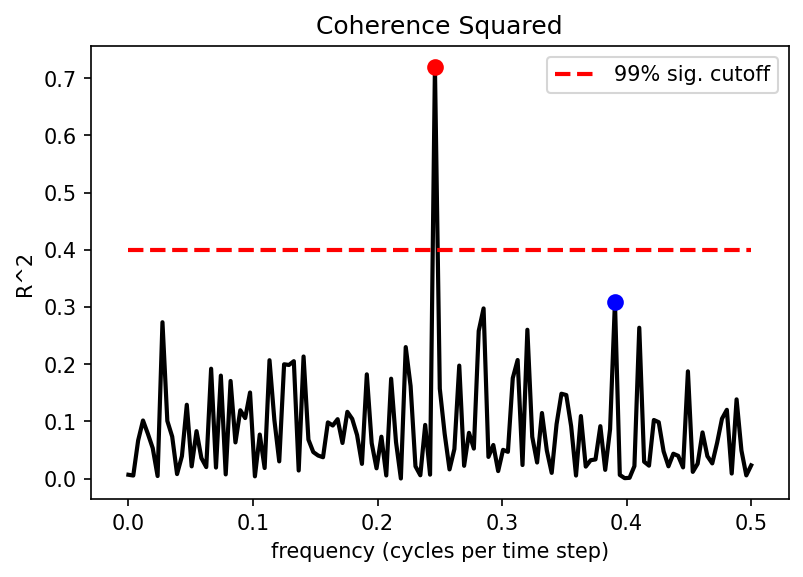

In [10]:
#%% plot the coherence and phase
MS = 7

# sort the peaks from largest to smallest to analyze later
j = np.argsort(Cxy)[::-1]

plt.figure()
plt.plot(F,Cxy,'-k',linewidth = 2)
plt.plot(F[j[0]],Cxy[j[0]],'or',linewidth = 2,markersize = MS)
plt.plot(F[j[1]],Cxy[j[1]],'ob',linewidth = 2,markersize = MS)

plt.ylabel('R^2')
plt.xlabel('frequency (cycles per time step)')
plt.xlim(-.03,.53)

# determine coherence-squared significance
dof = 2*num_chunks
fval = stats.f.ppf(0.99, 2, dof - 2)
r2_cutoff = fval / (num_chunks - 1. + fval)

plt.plot(F,np.ones(np.size(F))*r2_cutoff,'--r',linewidth = 2, label = '99% sig. cutoff')

plt.legend()
plt.title('Coherence Squared')
plt.show()


What do we see? First, we see that x and y only appear to oscillate _together_ at a single frequency - namely about 0.25 cycles/time step. So, even though y shows oscillatory behaviour at freq = 0.04, this is not popping out since x doesn't oscillate at this frequency as well. Now what about the phasing? That is what the quadrature spectrum is for.

In [11]:
# caculate the quadrature spectrum (phase)
P = -np.angle(Pxy, deg = True)

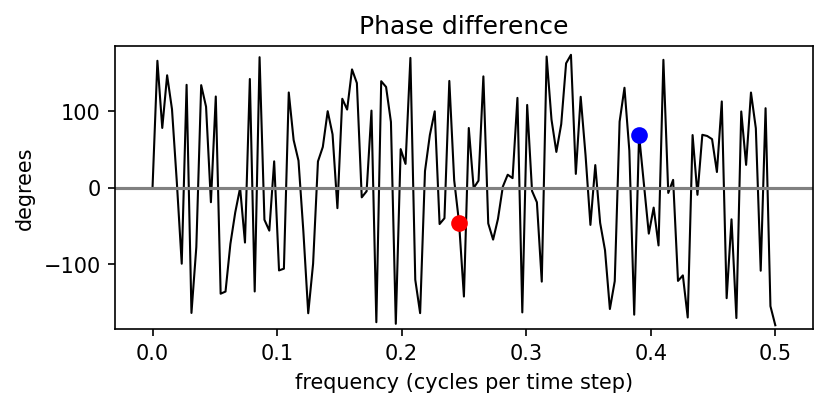

-------------------------------------
            PERIOD ........... PHASE
   RED:     4.0 dys.        -46.0 deg.
   BLUE:    3.0 dys.        69.0 deg.


In [12]:
#%% plot the quadrature spectrum
plt.figure(figsize=(6,2.5))
plt.plot(F,P,'-k',linewidth = 1)
plt.plot(F[j[0]],P[j[0]],'or',linewidth = 1,markersize = MS)
plt.plot(F[j[1]],P[j[1]],'ob',linewidth = 1,markersize = MS)

plt.title('Phase difference')
plt.ylabel('degrees')
plt.xlabel('frequency (cycles per time step)')
plt.xlim(-.03,.53)
plt.ylim(-185,185)
plt.axhline(y=0,color='gray')
plt.show()

print('-------------------------------------')
print('            PERIOD ........... PHASE')
print('   RED:     ' + str(np.round(1./F[j[0]],0)) + ' dys.        ' + str(np.round(P[j[0]])) + ' deg.')
print('   BLUE:    ' + str(np.round(1./F[j[1]],0)) + ' dys.        ' + str(np.round(P[j[1]])) + ' deg.')

Each frequency in our coherence plot has an associated phase in our quadrature plot. To make comparison easier, I have colored a red dot and blue dot to denote the same frequencies in both panels. This shows us that the period that x and y both oscillate at (freq = 0.25 cycles/time step = 4 days) has a phasing of 46 degrees. Recall that we coded-in pi/4...wow! Note that it won't always be that close, but it should be close(ish) if the analysis was done correctly.

Now, the blue dot shows a phasing of 69 degrees out of phase, but since the coherence squared itself didn't appear very big, we should ignore this. We will always get a value in the quadrature spectrum - however, if the coherence squared is small then this phasing is meaningless!